In [215]:
import json
import math
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [181]:
# Load data
artists_dict = json.load(open("data/artists_2k.json", "r"))
related_dict = json.load(open("data/related_2k.json", "r"))

In [182]:
# Build graph
G = nx.Graph()
for artist, related in related_dict.items():
    for next_artist in related:
        G.add_edge(artist, next_artist)

In [183]:
# Print basic graph properties
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
connected = nx.is_connected(G)
print("Connectivity: ", connected)
if connected:
    print("Diameter: ", nx.diameter(G))
print("Average clustering coefficient: ", nx.average_clustering(G))

Number of nodes:  2013
Number of edges:  8254
Connectivity:  True
Diameter:  12
Average clustering coefficient:  0.3686915029033288


In [184]:
# Compute betweenness centrality
between = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)

In [185]:
def get_most_central(n, centralities):
    return sorted(centralities, key=centralities.get, reverse=True)[:n]

In [204]:
# Number of clusters to analyze
num_clusters = 15

In [207]:
# Get bridges
bridges = nx.bridges(G)

In [208]:
# Partition graph
def partition(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [ ]:
communities = partition(num_clusters, G)

In [232]:
# Compute inverse document frequencies
idf = defaultdict(int)
for partition in communities:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

In [233]:
# Get most common genre in partition
def get_name(node_list):
    counts = defaultdict(int)
    for node in node_list:
        genres = artists_dict[node]["genres"]
        for genre in genres:
            counts[genre.replace(" ", "_")] += 1
    tf_idf = {k: v * idf[k] for k, v in counts.items()}
    return max(tf_idf, key=tf_idf.get)

In [236]:
# Get center of each partition
labels = {}
for community in communities:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    print(artists_dict[center]["name"], name)

88GLAM trap
Christian French pop edm
Meek Mill southern hip hop
Meghan Trainor post-teen pop
Duckwrth underground hip hop
Kelly Rowland hip pop
Canaan Smith contemporary country
Asian Doll trap queen
Steel Banglez uk hip hop
Panic! At The Disco pop punk
Rich Brian indonesian hip hop
Becky G latin
MAGIC! jawaiian
Josh X deep pop r&b
Lotto Boyzz uk hip hop


In [212]:
# Generate colors and labels for graph
colors = []
for node in G.nodes():
    for i in range(len(communities)):
        if node in communities[i]:
            colors.append(i)

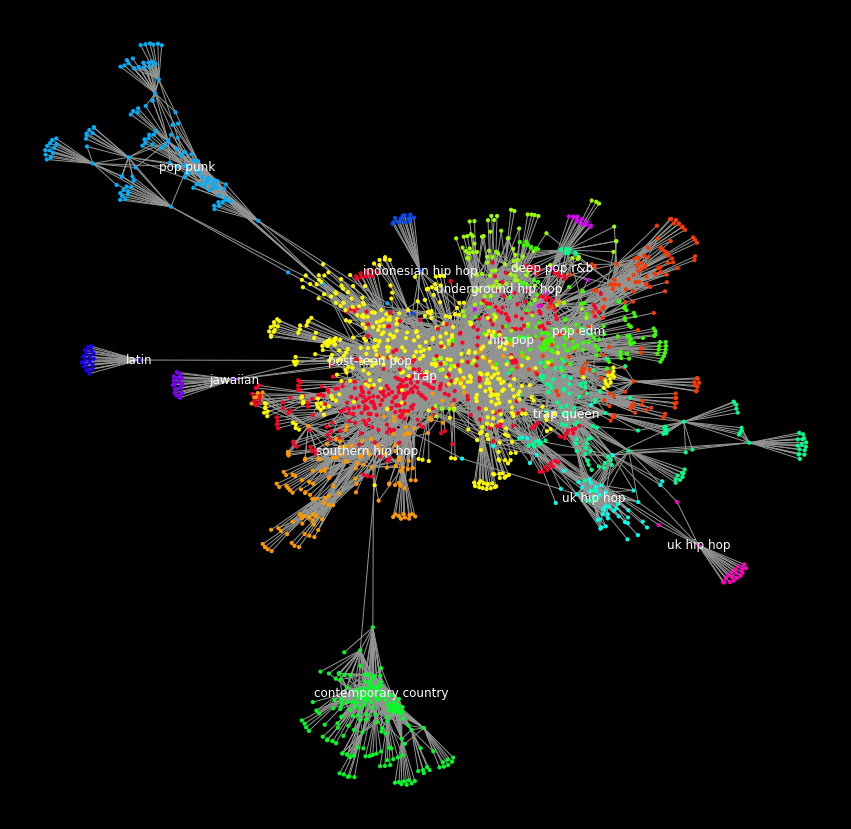

In [246]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_networkx(G, node_size=10, edge_color="#929591", cmap=plt.cm.gist_rainbow, node_color=colors, labels=labels, font_color="w")
ax.axis("off")
fig.set_facecolor('k')
plt.show()